Model 3 RNN 

In [4]:
%load_ext autoreload
%autoreload 2

In [135]:
import preproc_RNN_LSTM
import pandas as pd
import plot_evaluate_models
import matplotlib.pyplot as plt
from metrics import get_baseline_data
import numpy as np
import math
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from baseline import get_baseline_actual, get_baseline_predictions, forecast_accuracy

# Import imput data

In [366]:
data =preproc_RNN_LSTM.get_baseline_data("raw_data/preproc_data_rate.csv")

# Set parameters

In [369]:
data.columns

Index(['Date', 'Anchieta', 'Bangu', 'Barra da Tijuca', 'Botafogo',
       'Campo Grande', 'Centro', 'Cidade de Deus', 'Complexo do Alemao',
       'Copacabana', 'Guaratiba', 'Ilha do Governador', 'Inhauma', 'Iraja',
       'Jacarepagua', 'Jacarezinho', 'Lagoa', 'Madureira', 'Mare', 'Meier',
       'Pavuna', 'Portuaria', 'Ramos', 'Realengo', 'Rio Comprido', 'Rocinha',
       'Santa Cruz', 'Santa Teresa', 'Sao Cristovao', 'Tijuca', 'Vila Isabel'],
      dtype='object')

In [342]:
n_sequences=4000
length=100
prediction_horizon = 31

# Modelling

## set training and test set

In [343]:
X_train, y_train, X_test, y_test = preproc_RNN_LSTM.get_train_test(data,n_sequences,length, prediction_horizon)

In [344]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3000, 69, 30), (3000, 31, 30), (750, 69, 30), (750, 31, 30))

## define model

In [346]:
#model1 = preproc_RNN_LSTM.model(n_sequences, length-prediction_horizon, 30, prediction_horizon)

model1 = models.Sequential()
model1.add(layers.LSTM(128, return_sequences=False, activation="tanh", \
    input_shape = (length-prediction_horizon, 30)))
model1.add(layers.RepeatVector(prediction_horizon))
#model.add(Dropout(0.4))
model1.add(layers.LSTM(40, return_sequences=True, activation="tanh"))
# added 
#model.add(BatchNormalization())
#model.add(Dropout(0.4))
model1.add(layers.TimeDistributed(layers.Dense(30,"relu")))
model1.compile(loss="mse",
            optimizer="rmsprop")

## train model

In [347]:
#preproc_RNN_LSTM.fit_model(X_train, y_train, model1)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)
hist = model1.fit(X_train, y_train, 
                 callbacks=[es],
                 epochs = 2000,
                 validation_split =0.3, 
                 batch_size=16
                )

Epoch 1/2000
132/132 [==============================] - 7s 33ms/step - loss: 0.0493 - val_loss: 0.0473
Epoch 2/2000
132/132 [==============================] - 4s 29ms/step - loss: 0.0458 - val_loss: 0.0468
Epoch 3/2000
132/132 [==============================] - 4s 28ms/step - loss: 0.0443 - val_loss: 0.0445
Epoch 4/2000
132/132 [==============================] - 4s 28ms/step - loss: 0.0435 - val_loss: 0.0464
Epoch 5/2000
132/132 [==============================] - 4s 31ms/step - loss: 0.0423 - val_loss: 0.0438
Epoch 6/2000
132/132 [==============================] - 5s 38ms/step - loss: 0.0419 - val_loss: 0.0426
Epoch 7/2000
132/132 [==============================] - 4s 33ms/step - loss: 0.0410 - val_loss: 0.0416
Epoch 8/2000
132/132 [==============================] - 4s 32ms/step - loss: 0.0402 - val_loss: 0.0406
Epoch 9/2000
132/132 [==============================] - 4s 31ms/step - loss: 0.0397 - val_loss: 0.0414
Epoch 10/2000
132/132 [==============================] - 4s 31ms/step - l

Epoch 80/2000
132/132 [==============================] - 4s 33ms/step - loss: 0.0256 - val_loss: 0.0261
Epoch 81/2000
132/132 [==============================] - 4s 33ms/step - loss: 0.0250 - val_loss: 0.0282
Epoch 82/2000
132/132 [==============================] - 4s 30ms/step - loss: 0.0260 - val_loss: 0.0295
Epoch 83/2000
132/132 [==============================] - 4s 30ms/step - loss: 0.0264 - val_loss: 0.0268
Epoch 84/2000
132/132 [==============================] - 4s 30ms/step - loss: 0.0249 - val_loss: 0.0278
Epoch 85/2000
132/132 [==============================] - 4s 33ms/step - loss: 0.0246 - val_loss: 0.0290
Epoch 86/2000
132/132 [==============================] - 4s 31ms/step - loss: 0.0248 - val_loss: 0.0304
Epoch 87/2000
132/132 [==============================] - 4s 32ms/step - loss: 0.0245 - val_loss: 0.0246
Epoch 88/2000
132/132 [==============================] - 4s 29ms/step - loss: 0.0247 - val_loss: 0.0295
Epoch 89/2000
132/132 [==============================] - 4s 29ms

# Check outputs

## Check validation set

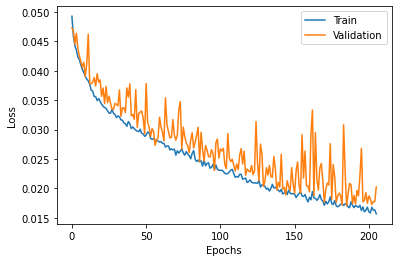

In [348]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

## Check predicted vs actual on test set

In [363]:
y_pred = plot_evaluate_models.compute_pred_test(data,model1,length, prediction_horizon)

/Users/desireepetrilli/Documents/event-forecast-rio/baseline.py:19: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  baseline_mean = baseline_data.mean().to_frame().T


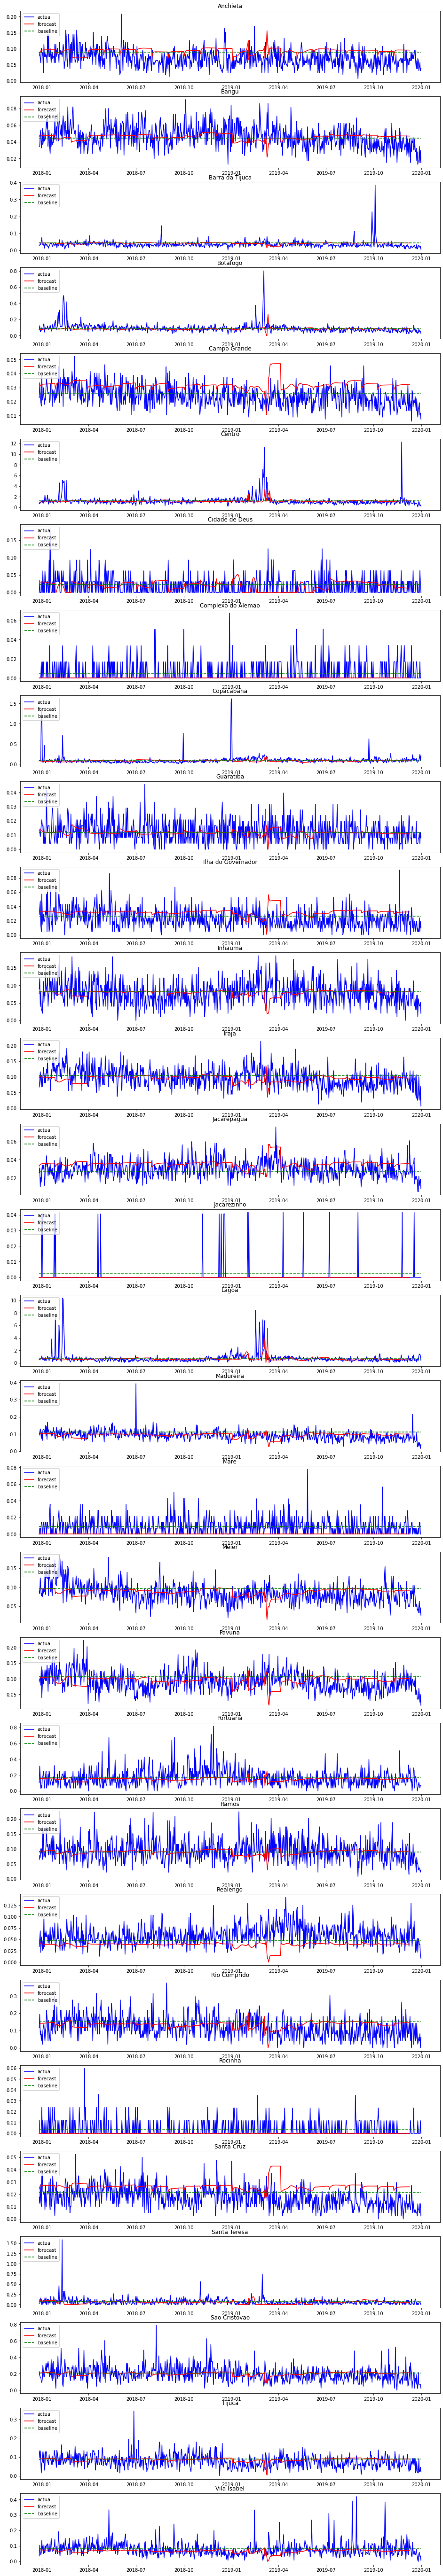

In [364]:
plot_evaluate_models.plot_actual_pred_test(data,model1, length, prediction_horizon)

In [353]:
error = plot_evaluate_models.error_actual_pred_baseline(data,y_pred,length, prediction_horizon)

/Users/desireepetrilli/Documents/event-forecast-rio/baseline.py:19: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  baseline_mean = baseline_data.mean().to_frame().T


In [354]:
error

,error_baseline,error_prediction
Anchieta,0.027359,0.030934
Bangu,0.010589,0.010637
Barra da Tijuca,0.014586,0.013673
Botafogo,0.028518,0.029441
Campo Grande,0.006256,0.009284
Centro,0.402029,0.407375
Cidade de Deus,0.021297,0.021987
Complexo do Alemao,0.007647,0.005511
Copacabana,0.042601,0.046110
Guaratiba,0.006022,0.006355
